# **Crop Calendar Dataset Preparation**

## **Import Required Libraries**

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rio
import gzip
import os
from io import BytesIO
import geopandas as gpd
from shapely.geometry import mapping
from scipy import stats as st
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = "Times New Roman"

## **Read the Data**

In [226]:
# Define the data path
data_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\all_crops_crop_calendar_2000"
file_names = os.listdir(data_path)

# Read the crop calendar data for Maize
with gzip.open(os.path.join(data_path, "Maize.crop.calendar.fill.nc.gz"), "rb") as f:
    maize_major_data = f.read()

with gzip.open(os.path.join(data_path, "Maize.2.crop.calendar.fill.nc.gz"), "rb") as f:
    maize_second_data = f.read()

In [227]:
# Read the data as NetCDF Xarray Dataset format
maize_major_ds = xr.open_dataset(maize_major_data)
maize_second_ds = xr.open_dataset(maize_second_data)

In [228]:
# Set spatial dimensions to the datasets
maize_major_ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
maize_major_ds.rio.write_crs("epsg:4326", inplace=True)

maize_second_ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
maize_second_ds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset> Size: 523MB
Dimensions:        (latitude: 2160, longitude: 4320)
Coordinates:
  * latitude       (latitude) float64 17kB 89.96 89.88 89.79 ... -89.88 -89.96
  * longitude      (longitude) float64 35kB -180.0 -179.9 -179.8 ... 179.9 180.0
    spatial_ref    int32 4B 0
Data variables:
    filled.index   (latitude, longitude) float32 37MB ...
    harvest        (latitude, longitude) float32 37MB ...
    harvest.end    (latitude, longitude) float32 37MB ...
    harvest.range  (latitude, longitude) timedelta64[ns] 75MB ...
    harvest.start  (latitude, longitude) float32 37MB ...
    index          (latitude, longitude) float32 37MB ...
    plant          (latitude, longitude) float32 37MB ...
    plant.end      (latitude, longitude) float32 37MB ...
    plant.range    (latitude, longitude) timedelta64[ns] 75MB ...
    plant.start    (latitude, longitude) float32 37MB ...
    tot.days       (latitude, longitude) timedelta64[ns] 75MB ...
Attributes:
    notes:    No spatial extrapolation done

## **Read the Shapefile and Clip the Data**

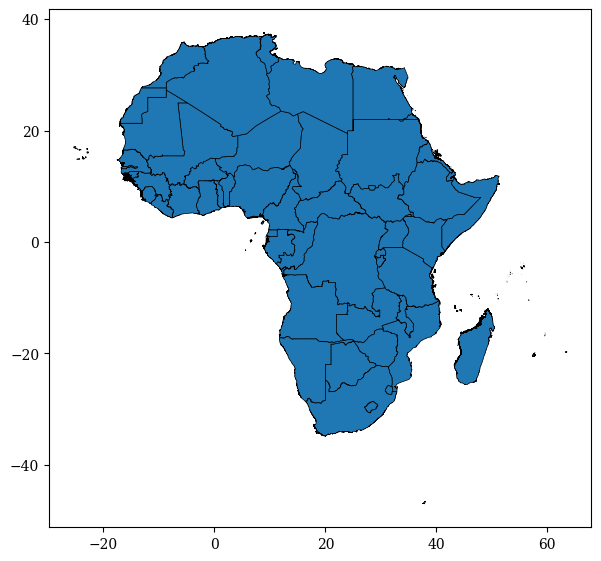

In [229]:
# Read the Africa country shapefile
africa_gdf = gpd.read_file(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\Africa_Country_Boundary\afr_g2014_2013_0.shp")
africa_gdf.plot(edgecolor="black", linewidth=0.5, figsize=(7, 7));

In [230]:
# Write a function to extract crop calendar information for each country of a particular crop

def prepare_crop_calendar_data(roi_shp, roi_country_col, crop_calendar_nc, variable_names, new_col_names):

    # Create a blank dataframe to store the final data
    final_data = []

    # Iterate over each country
    for country in tqdm(roi_shp[roi_country_col].unique()):
        country_geom = roi_shp[roi_shp[roi_country_col]==country].geometry
        country_specific_data = [country]

        # Iterate over each variable
        for variable in variable_names:
            country_data = crop_calendar_nc[variable].rio.clip(country_geom.apply(mapping), roi_shp.crs, drop=True)
            country_data = country_data.values.flatten()

            # Drop all the NaN values
            coutry_data_non_null = country_data[~np.isnan(country_data)]

            # Calculate most frequent values
            country_mode = st.mode(coutry_data_non_null)[0]

            country_specific_data.append(country_mode)

        final_data.append(country_specific_data)

    final_df = pd.DataFrame(final_data, columns=new_col_names)

    return final_df

In [231]:
# Define the important variable names
variable_names = ["plant", "plant.start", "plant.end", "harvest", "harvest.start", "harvest.end"]

# Define all the column names in the final data
column_names = ["country", "plant", "plant_start", "plant_end", "harvest", "harvest_start", "harvest_end"]

# Apply the function on both the dataset
maize_major_crop_calendar_df = prepare_crop_calendar_data(africa_gdf, "ADM0_NAME", maize_major_ds, variable_names, column_names)
maize_second_crop_calendar_df = prepare_crop_calendar_data(africa_gdf, "ADM0_NAME", maize_second_ds, variable_names, column_names)

100%|██████████| 59/59 [00:53<00:00,  1.11it/s]


## **Plot the Data**

In [232]:
# Change the name of the "ADM0_NAME" column in the shapefile
africa_gdf.rename(columns={"ADM0_NAME": "country"}, inplace=True)

# Join the crop calendar data with the shapefile
maize_major_crop_calendar_gdf = pd.merge(left=africa_gdf[["country", "geometry"]], right=maize_major_crop_calendar_df,
                                         on=["country"], how="inner")

maize_second_crop_calendar_gdf = pd.merge(left=africa_gdf[["country", "geometry"]], right=maize_second_crop_calendar_df,
                                         on=["country"], how="inner")

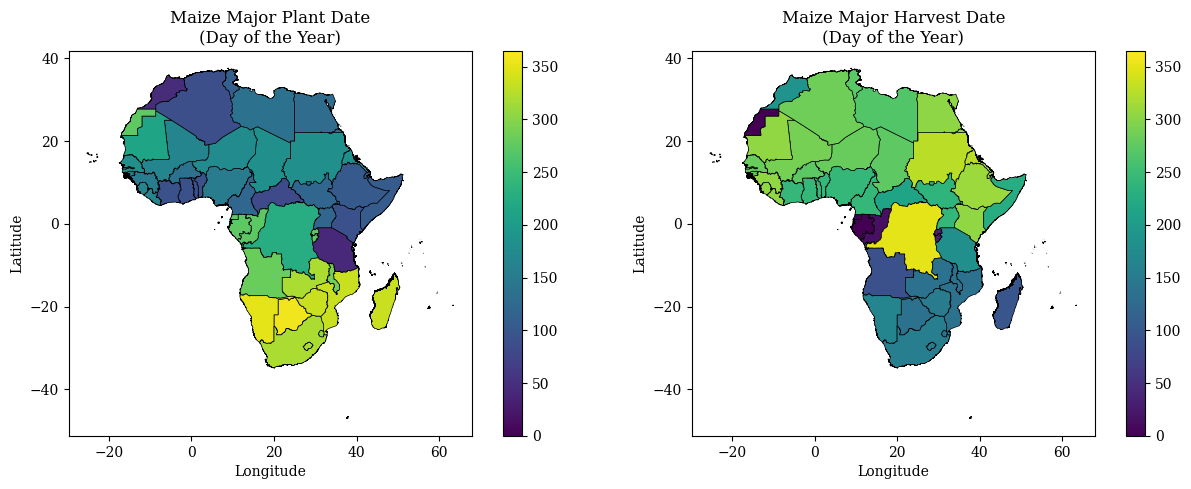

In [233]:
# Plot the Maize Major data
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))
axes = axes.flatten()

maize_major_crop_calendar_gdf.plot(ax=axes[0], column="plant", cmap="viridis", vmin=0, vmax=365,
                                   edgecolor="black", linewidth=0.5, legend=True)
axes[0].set_title("Maize Major Plant Date\n(Day of the Year)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")


maize_major_crop_calendar_gdf.plot(ax=axes[1], column="harvest", cmap="viridis", vmin=0, vmax=365,
                                   edgecolor="black", linewidth=0.5, legend=True)
axes[1].set_title("Maize Major Harvest Date\n(Day of the Year)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.subplots_adjust(wspace=0.01);

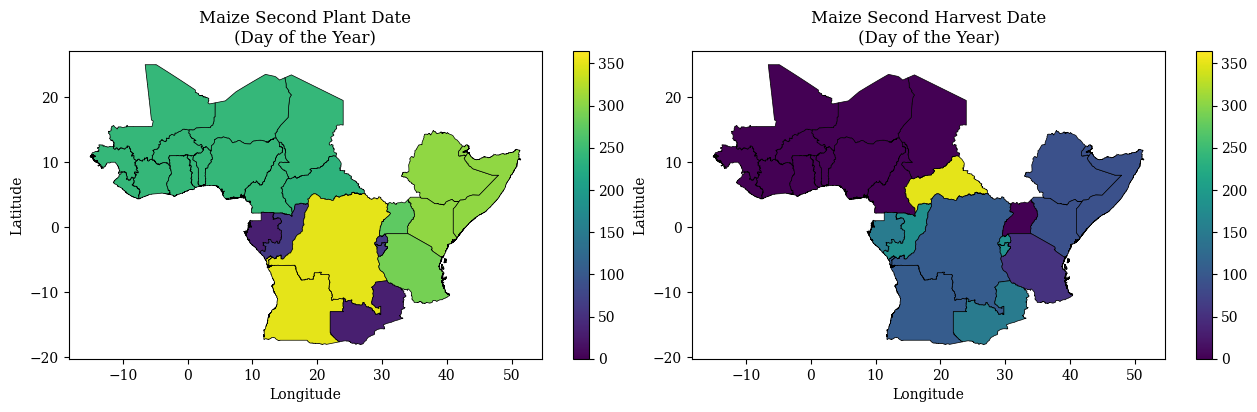

In [234]:
# Plot the Maize Second data
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
axes = axes.flatten()

maize_second_crop_calendar_gdf.plot(ax=axes[0], column="plant", cmap="viridis", vmin=0, vmax=365,
                                   edgecolor="black", linewidth=0.5, legend=True)
axes[0].set_title("Maize Second Plant Date\n(Day of the Year)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

maize_second_crop_calendar_gdf.plot(ax=axes[1], column="harvest", cmap="viridis", vmin=0, vmax=365,
                                   edgecolor="black", linewidth=0.5, legend=True)
axes[1].set_title("Maize Second Harvest Date\n(Day of the Year)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.subplots_adjust(wspace=0.01);

## **Export the Data**

In [242]:
# Export the dataframes
output_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\processed_datasets"

# with pd.ExcelWriter(os.path.join(output_path, "crop_calendar_ssa.xlsx"), mode="w") as writer:
#     maize_major_crop_calendar_df.sort_values(by="country").to_excel(writer, sheet_name="maize_major", index=False)
#     maize_second_crop_calendar_df.sort_values(by="country").to_excel(writer, sheet_name="maize_second", index=False)